In [63]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from matplotlib import cm
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import scipy
from matplotlib import cm

# Direct input
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : 20,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params)
plt.style.use('seaborn-dark-palette')
# plt.style.use('ggplot')

np.random.seed(42)

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from models.VAE import VariationalAutoEncoder

In [9]:
"""Define configs for synthetic 2D Gaussian data"""
x_range, y_range = np.linspace(-7, 5, 500), np.linspace(-3, 3, 500)

mean_1, mean_2 = np.array([-4.0, 0.0]), np.array([2.0, 0.0])
cov_1, cov_2 = np.array([[0.5, 0.5], [0.5, 0.8]]), np.array([[1, -0.8], [-0.8, 1]])


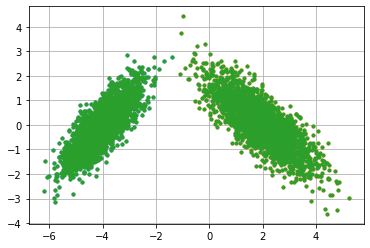

In [11]:
# Sample points from the Gaussian mixtures
# We actually need to draw from a binomial distribution to get the number of required samples from each distribution. 
# But for now we sample from each Gaussian the same number of points

dataset_size = 5000

sampled_gauss_1 = np.random.multivariate_normal(mean_1, cov_1, size=dataset_size // 2).astype(np.float32)

sampled_gauss_2 = np.random.multivariate_normal(mean_2, cov_2, size=dataset_size // 2).astype(np.float32)

plt.plot(sampled_gauss_1[:, 0], sampled_gauss_1[:, 1], ".")
plt.plot(sampled_gauss_2[:, 0], sampled_gauss_2[:, 1], ".")

joint_data = np.concatenate((sampled_gauss_1, sampled_gauss_2))
np.random.shuffle(joint_data)

plt.plot(joint_data[:, 0], joint_data[:, 1], ".")
plt.grid()


In [11]:
tensora = torch.from_numpy(np.random.random((3, 10, 4)))
tensorb = torch.from_numpy(np.random.random((3, 1, 4)))

tensorb_repeated = torch.repeat_interleave(tensorb, 10, 1)
# We're subtracting things wrt second dimension,
# where we do [X, 1, Z] - [X, Y, Z] ] and expect
# to see broadcasting wrt first tensor in a way of
# repeating the first tensor along second dim
# Y times

print(torch.sum(tensora - tensorb))
print(torch.sum(tensora - tensorb_repeated))

tensor_c = torch.randn((3, 4))
# Check the consistency of `view` function
tensora_1, tensora_2 = tensor_c.view((3, 2, 2))[..., 0], tensor_c.view((3, 2, 2))[..., 1]
print(tensor_c)

print(tensora_1)

print(tensora_2)

tensor_c_view = tensor_c.view((3, 2, 2))

print(tensor_c_view[0])


tensor(15.1605, dtype=torch.float64)
tensor(15.1605, dtype=torch.float64)
tensor([[ 0.0433, -0.5408, -1.5658, -0.6492],
        [-0.7697, -0.1772,  1.0820, -0.1233],
        [-0.1349,  0.8944, -1.1320,  0.7901]])
tensor([[ 0.0433, -1.5658],
        [-0.7697,  1.0820],
        [-0.1349, -1.1320]])
tensor([[-0.5408, -0.6492],
        [-0.1772, -0.1233],
        [ 0.8944,  0.7901]])
tensor([[ 0.0433, -0.5408],
        [-1.5658, -0.6492]])


In [14]:
vae = (
    VariationalAutoEncoder(2, [10], bottleneck_size=1, n_sample_z=1, kl_term_weight=0.5, loss="mse").train()
)
mse_sampling_loss_step = []
mse_loss_step = []
elbo_step = []
loss_step = []

In [16]:
epochs = 5000
batch_size = 256
optimizer = optim.Adam(vae.parameters(), lr=0.001)

torch_data = torch.from_numpy(joint_data.copy())

maximize_ELBO = True
for epoch in range(epochs):
    steps = joint_data.shape[0] // batch_size

    # reshuffle the data at each epoch to remain iid in SGD
    rand_idxes = torch.randperm(torch_data.shape[0])
    torch_data = torch_data[rand_idxes]

    for step in range(steps):
        batch = torch_data[step * batch_size : (step + 1) * batch_size]

        output_full = vae(batch)
        output_decoded = output_full["mu_x"]
        ELBO = vae.get_ELBO(batch, output_full).mean()
        MSE_loss = ((output_decoded - batch) ** 2).mean()

        if maximize_ELBO:
            loss = -ELBO
        else:
            loss = MSE_loss

        optimizer.zero_grad()
        loss.backward()

        # print(output_full["sigma_x"].grad)

        optimizer.step()

        loss_step.append(loss.mean().item())

        MSE_loss = MSE_loss.cpu()
        ELBO = ELBO.cpu()

        mse_loss_step.append(MSE_loss.clone().mean().detach().numpy())
        elbo_step.append(ELBO.mean().clone().detach().numpy())
    if epoch % 100 == 0:
        print(f"ELBO: {np.mean(elbo_step[-50:]):.2f} MSE: {np.mean(mse_loss_step[-50:]):.2f}")
        # pbar.set_description(f"ELBO: {np.mean(elbo_step[-50:]):.2f} MSE: {np.mean(mse_loss_step[-50:]):.2f}")

        # break


ELBO: -2798.99 MSE: 5.45
ELBO: -364.92 MSE: 0.24
ELBO: -345.52 MSE: 0.21
ELBO: -333.02 MSE: 0.21
ELBO: -325.61 MSE: 0.21
ELBO: -323.41 MSE: 0.21
ELBO: -323.05 MSE: 0.21
ELBO: -321.69 MSE: 0.21
ELBO: -322.04 MSE: 0.20
ELBO: -321.07 MSE: 0.20
ELBO: -320.90 MSE: 0.21
ELBO: -318.13 MSE: 0.20
ELBO: -319.25 MSE: 0.20
ELBO: -318.85 MSE: 0.20


KeyboardInterrupt: 

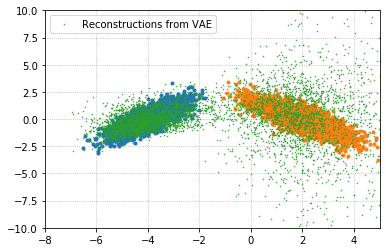

In [27]:
""" Display some reconstructed samples p(x|z) from the inferred latents z ~ p(z|x)"""
dataset_size = 5000

sampled_gauss_1 = np.random.multivariate_normal(mean_1, cov_1, size=dataset_size // 2).astype(np.float32)
sampled_gauss_2 = np.random.multivariate_normal(mean_2, cov_2, size=dataset_size // 2).astype(np.float32)
plt.figure(figsize=(6,4))

# sampled_gauss_2 =  np.random.multivariate_normal(mean_1, cov_1, size=(dataset_size//2, 2))

plt.plot(sampled_gauss_1[:, 0], sampled_gauss_1[:, 1], ".")
plt.plot(sampled_gauss_2[:, 0], sampled_gauss_2[:, 1], ".")

vae_output = vae(torch.tensor(joint_data))#.to(device))
vae_decoded = vae_output["decoded"].cpu().detach().numpy().reshape((-1, 2))

plt.plot(vae_decoded[:, 0], vae_decoded[:, 1], ".", alpha=1, markersize=1, label="Reconstructions from VAE")

plt.xlim((-8, 5))
plt.ylim((-10, 10))
plt.legend()
plt.grid(linestyle="dotted") 

# plt.savefig("vae_fit_gaussians.png", )


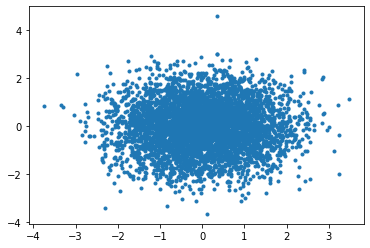

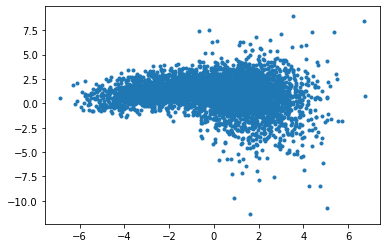

In [29]:
# Looks like we can recover the distirbutions, but can we sample?
# Take samples from N(0, I)
samples = np.random.normal(0, 1, size=(5000, 2)).astype(np.float32)

samples_torch = torch.from_numpy(samples)
plt.figure()
plt.plot(samples[:, 0], samples[:, 1], ".")
plt.show()

decoded_samples = vae(samples_torch)["decoded"].cpu().detach().numpy().reshape((-1, 2))

plt.figure()
plt.plot(decoded_samples[:, 0], decoded_samples[:, 1], ".")
plt.show()

# Not bad? Adjusting the weight for KL term would probably make it more reasonable. 

## MNIST (unsupervised, M1)

In [30]:
# Dataloader code adapted from https://gist.github.com/xmfbit/b27cdbff68870418bdb8cefa86a2d558
import os
import torchvision.datasets as dset
import torchvision.transforms as transforms

root = "./data"
if not os.path.exists(root):
    os.mkdir(root)

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1.0,))])
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)


9913344it [00:01, 5791262.35it/s]                              


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



29696it [00:00, 29196917.86it/s]         

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



1649664it [00:00, 5416702.08it/s]                            


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



5120it [00:00, 13990121.49it/s]         

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



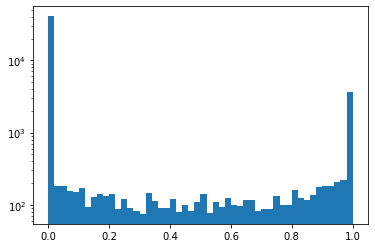

In [31]:
"""Take a look at the distribution of pixel intensities of the first sample""" 
batch0 = next(iter(train_loader))

plt.hist(batch0[0].numpy().flatten(), bins=50)
plt.yscale("log")


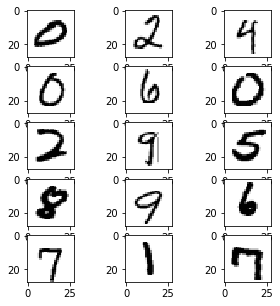

In [32]:
"""Show some samples from the dataset"""
fig, axes = plt.subplots(5, 3, figsize=(5, 5))

for i in range(5):
    for j in range(3):
        axes[i, j].imshow(batch0[0][i * 3 + j, 0].numpy(), cmap="binary")


In [ ]:
sampling_ae = (
    VariationalAutoEncoder(
        28 * 28,
        [200,200],
        bottleneck_size=2,
        n_sample_z=1,
        kl_term_weight=1.0,
        loss="cont_bern",
        output_activation=nn.Sigmoid(),
    )
    .train()
)

In [ ]:
vae = (
    VariationalAutoEncoder(
        28 * 28,
        [200,200],
        bottleneck_size=2,
        n_sample_z=1,
        kl_term_weight=1.0,
        loss="cont_bern",
        output_activation=nn.Sigmoid(),
    )
    .train()
)


In [ ]:
def train_model(model, maximize_ELBO=True, epochs=10):
    print("Starting")
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    bce_loss_step = []
    elbo_step = []
    loss_step = []

    bce_loss = nn.BCELoss(reduction="sum")

    batch = next(iter(train_loader))
    batch_input = batch[0].view(-1, 28 * 28)

    print(f"Len of the batch: {batch_input.shape[0]}")
    for epoch in range(epochs):
        for step, batch in enumerate(train_loader):
            batch_input = batch[0].view(-1, 28 * 28)

            output_full = model(batch_input)
            output_decoded = output_full["mu_x"]

            minibatch_const = 1 / batch_input.shape[0]

            ELBO = model.get_ELBO(batch_input, output_full) * minibatch_const
            bernoulli_loss = bce_loss(output_decoded, batch_input) * minibatch_const

            if maximize_ELBO:
                loss = -ELBO
            else:
                loss = bernoulli_loss

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            loss = loss.cpu()
            ELBO = ELBO.cpu()
            bernoulli_loss = bernoulli_loss.cpu()

            loss_step.append(loss.mean().item())

            bce_loss_step.append(bernoulli_loss.clone().mean().detach().numpy())
            elbo_step.append(ELBO.mean().clone().detach().numpy())
            if step % 1000 == 0:
                print(f"ELBO: {np.mean(elbo_step[-50:]):.2f} BCE loss: {np.mean(bce_loss_step[-50:]):.2f}")

                # break


In [52]:
train_model(sampling_ae, maximize_ELBO=False, epochs=100)

Starting
Len of the batch: 64
ELBO: -217.62 BCE loss: 163.93
ELBO: -249.58 BCE loss: 156.45
ELBO: -254.57 BCE loss: 155.84
ELBO: -265.38 BCE loss: 155.35
ELBO: -275.88 BCE loss: 153.72
ELBO: -271.31 BCE loss: 151.88
ELBO: -279.89 BCE loss: 151.27
ELBO: -286.11 BCE loss: 150.18
ELBO: -287.79 BCE loss: 151.26
ELBO: -303.09 BCE loss: 149.57
ELBO: -303.69 BCE loss: 148.54
ELBO: -308.00 BCE loss: 147.69
ELBO: -308.00 BCE loss: 148.92
ELBO: -313.19 BCE loss: 148.72
ELBO: -325.62 BCE loss: 147.27
ELBO: -330.82 BCE loss: 145.05
ELBO: -342.46 BCE loss: 144.65
ELBO: -346.02 BCE loss: 146.56
ELBO: -346.44 BCE loss: 145.04
ELBO: -344.86 BCE loss: 143.90
ELBO: -365.75 BCE loss: 143.13
ELBO: -355.43 BCE loss: 145.12


KeyboardInterrupt: 

In [53]:
train_model(vae, maximize_ELBO=True, epochs=100)

Starting
Len of the batch: 64
ELBO: -545.39 BCE loss: 545.38
ELBO: -196.62 BCE loss: 194.00
ELBO: -186.52 BCE loss: 183.63
ELBO: -173.92 BCE loss: 169.61
ELBO: -169.73 BCE loss: 165.05
ELBO: -167.01 BCE loss: 162.24
ELBO: -166.77 BCE loss: 162.01
ELBO: -165.69 BCE loss: 160.81
ELBO: -161.34 BCE loss: 156.40
ELBO: -161.93 BCE loss: 156.92
ELBO: -162.20 BCE loss: 157.10
ELBO: -160.58 BCE loss: 155.41
ELBO: -158.48 BCE loss: 153.18
ELBO: -157.17 BCE loss: 151.84
ELBO: -155.56 BCE loss: 150.16
ELBO: -156.56 BCE loss: 151.15
ELBO: -155.29 BCE loss: 149.88
ELBO: -154.06 BCE loss: 148.61
ELBO: -153.35 BCE loss: 147.83
ELBO: -154.17 BCE loss: 148.64
ELBO: -154.21 BCE loss: 148.61
ELBO: -153.27 BCE loss: 147.67
ELBO: -152.34 BCE loss: 146.67
ELBO: -153.65 BCE loss: 148.04
ELBO: -152.49 BCE loss: 146.82
ELBO: -151.77 BCE loss: 146.10
ELBO: -150.67 BCE loss: 144.96
ELBO: -151.13 BCE loss: 145.40
ELBO: -151.16 BCE loss: 145.44


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'

## Check the latent space (of the train data). Make use of the labels to inspect the quality of the features, in terms of discriminatory effects between classes

In [54]:
@torch.no_grad()
def do_inference(model, data):
    output = []
    inputs = []
    labels = []
    mu_zs = []
    mu_xs = []
    for batch in data:
        batch_input = batch[0].view(-1, 28 * 28)#.to(device)
        full_output = model(batch_input)
        labels.append(batch[1].numpy().squeeze())
        output.append(full_output)
        inputs.append(batch[0].numpy().squeeze())
        mu_zs.append(full_output["mu_z"].cpu().detach().numpy().squeeze())
        mu_xs.append(full_output["mu_x"].cpu().detach().numpy().squeeze().reshape((-1, 28, 28)))
    return {
        "full_output": output,
        "inputs": np.concatenate(inputs, axis=0),
        "labels": np.concatenate(labels, axis=0),
        "mu_zs": np.concatenate(mu_zs, axis=0),
        "mu_xs": np.concatenate(mu_xs, axis=0),
    }


In [55]:
train_outputs_vae = do_inference(vae, test_loader)
train_outputs_sampled_ae = do_inference(sampling_ae, test_loader)


In [56]:
norm = plt.Normalize()
colors = np.array(plt.cm.jet(np.linspace(0, 1, 10)))

print(colors)


[[0.         0.         0.5        1.        ]
 [0.         0.         0.99910873 1.        ]
 [0.         0.37843137 1.         1.        ]
 [0.         0.83333333 1.         1.        ]
 [0.30044276 1.         0.66729918 1.        ]
 [0.66729918 1.         0.30044276 1.        ]
 [1.         0.90123457 0.         1.        ]
 [1.         0.48002905 0.         1.        ]
 [0.99910873 0.07334786 0.         1.        ]
 [0.5        0.         0.         1.        ]]


Text(0.5, 1.0, '$p(z \\mid x)$ of the AE')

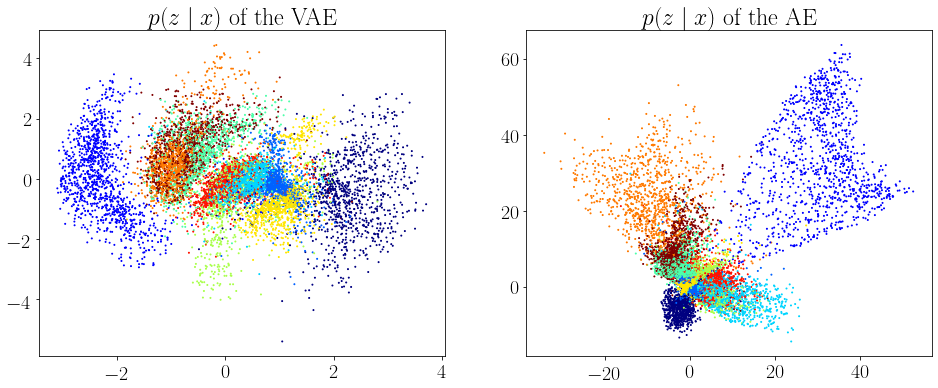

In [67]:
"""Look at the distrbution of the posterior p(z|x)""" 

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
cols = colors[train_outputs_vae["labels"]]
axes[0].scatter(train_outputs_vae["mu_zs"][:, 0], train_outputs_vae["mu_zs"][:, 1], c=cols, s=1)
# axes[0].grid()
axes[0].set_title("$p(z \mid x)$ of the VAE")

axes[1].scatter(train_outputs_sampled_ae["mu_zs"][:, 0], train_outputs_sampled_ae["mu_zs"][:, 1], c=cols, s=1)
axes[1].set_title("$p(z \mid x)$ of the AE")

# plt.legend()
# axes[1].grid()


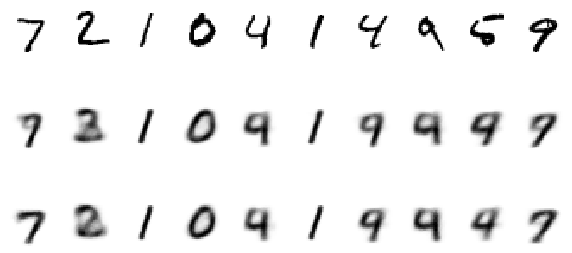

In [70]:
"""
Look at (original,reconstructed) pairs
"""
fig, axes = plt.subplots(3, 10, figsize=(10, 5))

for i in range(10):
    axes[0, i].imshow(train_outputs_vae["inputs"][i], cmap="binary")
    axes[0,i].axis("off")

for i in range(10):
    axes[1, i].imshow(train_outputs_vae["mu_xs"][i], cmap="binary")
    axes[1,i].axis("off")

for i in range(10):
    axes[2, i].imshow(train_outputs_sampled_ae["mu_xs"][i], cmap="binary")
    axes[2,i].axis("off")
# axes[0,0].set_title("asd")


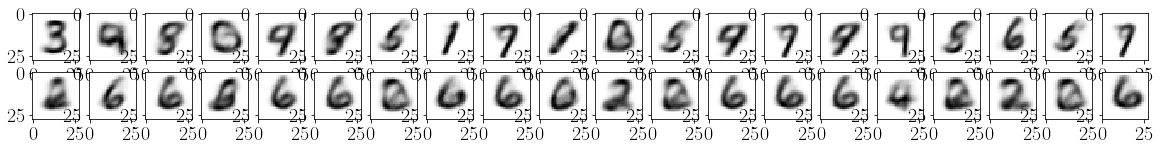

In [74]:
"""
Sample from N(0, I) and reconstruct using the models
"""

train_outputs_vae = None
train_outputs_sampled_ae = None
fig, axes = plt.subplots(2, 20, figsize=(20, 2))

zs = []
# device_old = device
# device = "cpu"
# vae = vae.to("cpu")
# sampling_ae = sampling_ae.to("cpu")
for i in range(20):
    z = torch.from_numpy(np.random.randn(1, 2)).float()

    decoded_vae = vae.decode(z, z)[0].squeeze().detach().numpy().reshape((28, 28))
    decoded_ae = sampling_ae.decode(z[:, :2], z[:, :2])[0].squeeze().detach().numpy().reshape((28, 28))

    axes[0, i].imshow(decoded_vae, cmap="binary")
    axes[1, i].imshow(decoded_ae, cmap="binary")

# device = device_old
# vae = vae.to(device)
# sampling_ae = sampling_ae.to(device)


[-1.64485363 -1.29669299 -1.05927692 -0.87016448 -0.7079966  -0.56263389
 -0.42831603 -0.30133652 -0.17905472 -0.05940243  0.05940243  0.17905472
  0.30133652  0.42831603  0.56263389  0.7079966   0.87016448  1.05927692
  1.29669299  1.64485363]


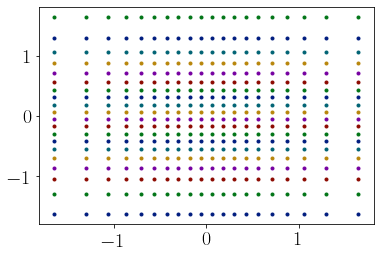

In [75]:
"""
Display the digit manifold in 2D space. 

To achieve this, note that the prior is an independent Gaussian, so 
it's sufficient to take 1D Gaussian, take interval points from uniform
regions that correspond to the Gaussian CDF and reconstruct at those points 
"""

interval_size = 20

from scipy.stats import norm

pnts_z_1d = norm.ppf(np.linspace(1.0 / interval_size, 1.0 - 1.0 / interval_size, interval_size))

print(pnts_z_1d)

crossed = np.array([[(x, y) for y in pnts_z_1d] for x in pnts_z_1d])

plt.plot(crossed[:, :, 0], crossed[:, :, 1], ".")


In [76]:
# Check CDF on x-axis
from scipy.stats import multivariate_normal

rv = multivariate_normal([0.0, 0.0])

lst = 0
block_areas = []
for i in range(1, crossed.shape[0]):  # x
    for j in range(1, crossed.shape[1]):  # y
        cdf_lst_left = rv.cdf([crossed[i - 1, j][0], crossed[i - 1, j][1]])
        cdf_lst_down = rv.cdf([crossed[i, j - 1][0], crossed[i, j - 1][1]])
        cdf_lst_left_down = rv.cdf([crossed[i - 1, j - 1][0], crossed[i - 1, j - 1][1]])

        cdf_here = rv.cdf([crossed[i, j][0], crossed[i, j][1]])

        this_block_area = cdf_here - cdf_lst_down - cdf_lst_left + cdf_lst_left_down
        block_areas.append(this_block_area)
print(block_areas[1] * len(block_areas))  # - borders
assert np.max(block_areas) - np.min(block_areas) <= 1e-4, "The space is not mapped to the circle equally"


0.8100000000000016


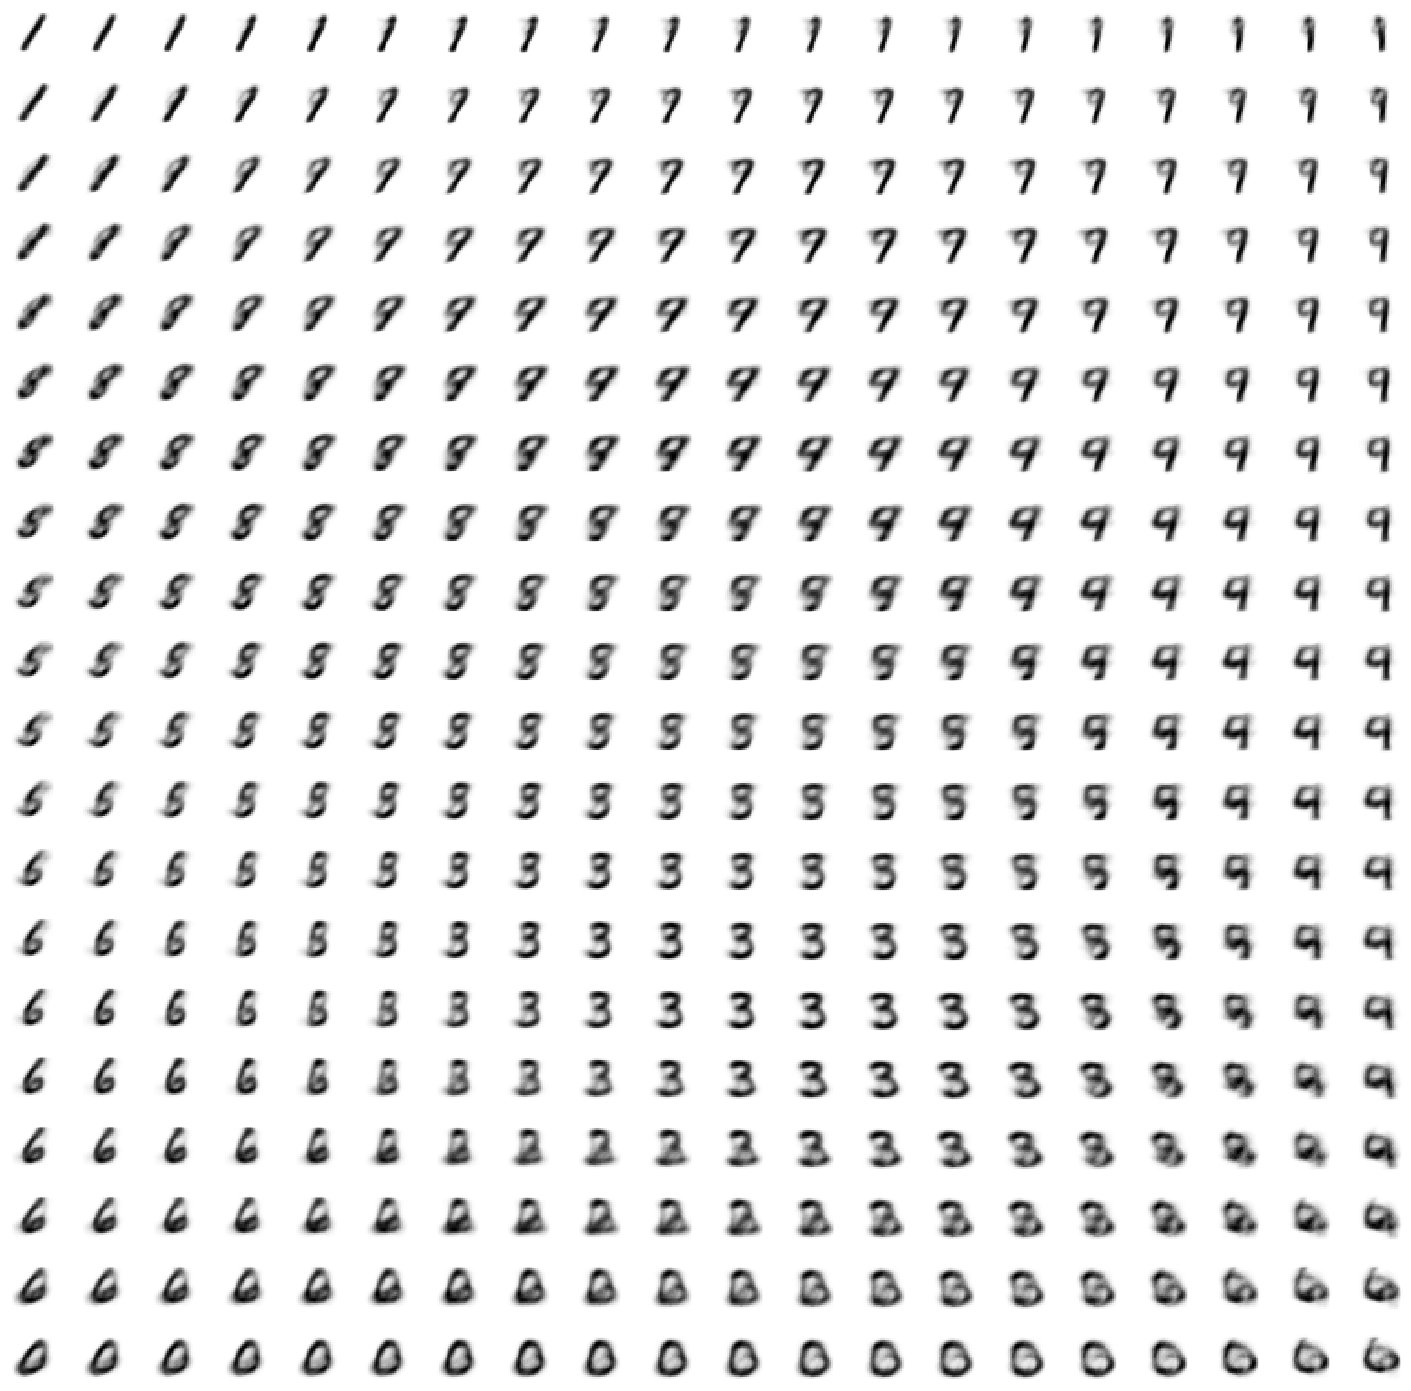

In [78]:
fig, axes = plt.subplots(20, 20, figsize=(20, 20))

for i in range(20):
    for j in range(20):
        z = torch.from_numpy(crossed[i, j][None, :]).float()

        decoded_vae = vae.decode(z, z)[0].squeeze().detach().numpy().reshape((28, 28))

        axes[i, j].imshow(decoded_vae, cmap="binary")
        axes[i, j].axis("off")
fig.tight_layout()
fig.subplots_adjust(hspace=0)
# plt.savefig("plots/mnist_manifold_unsupervised.png", dpi=300)
plt.show()


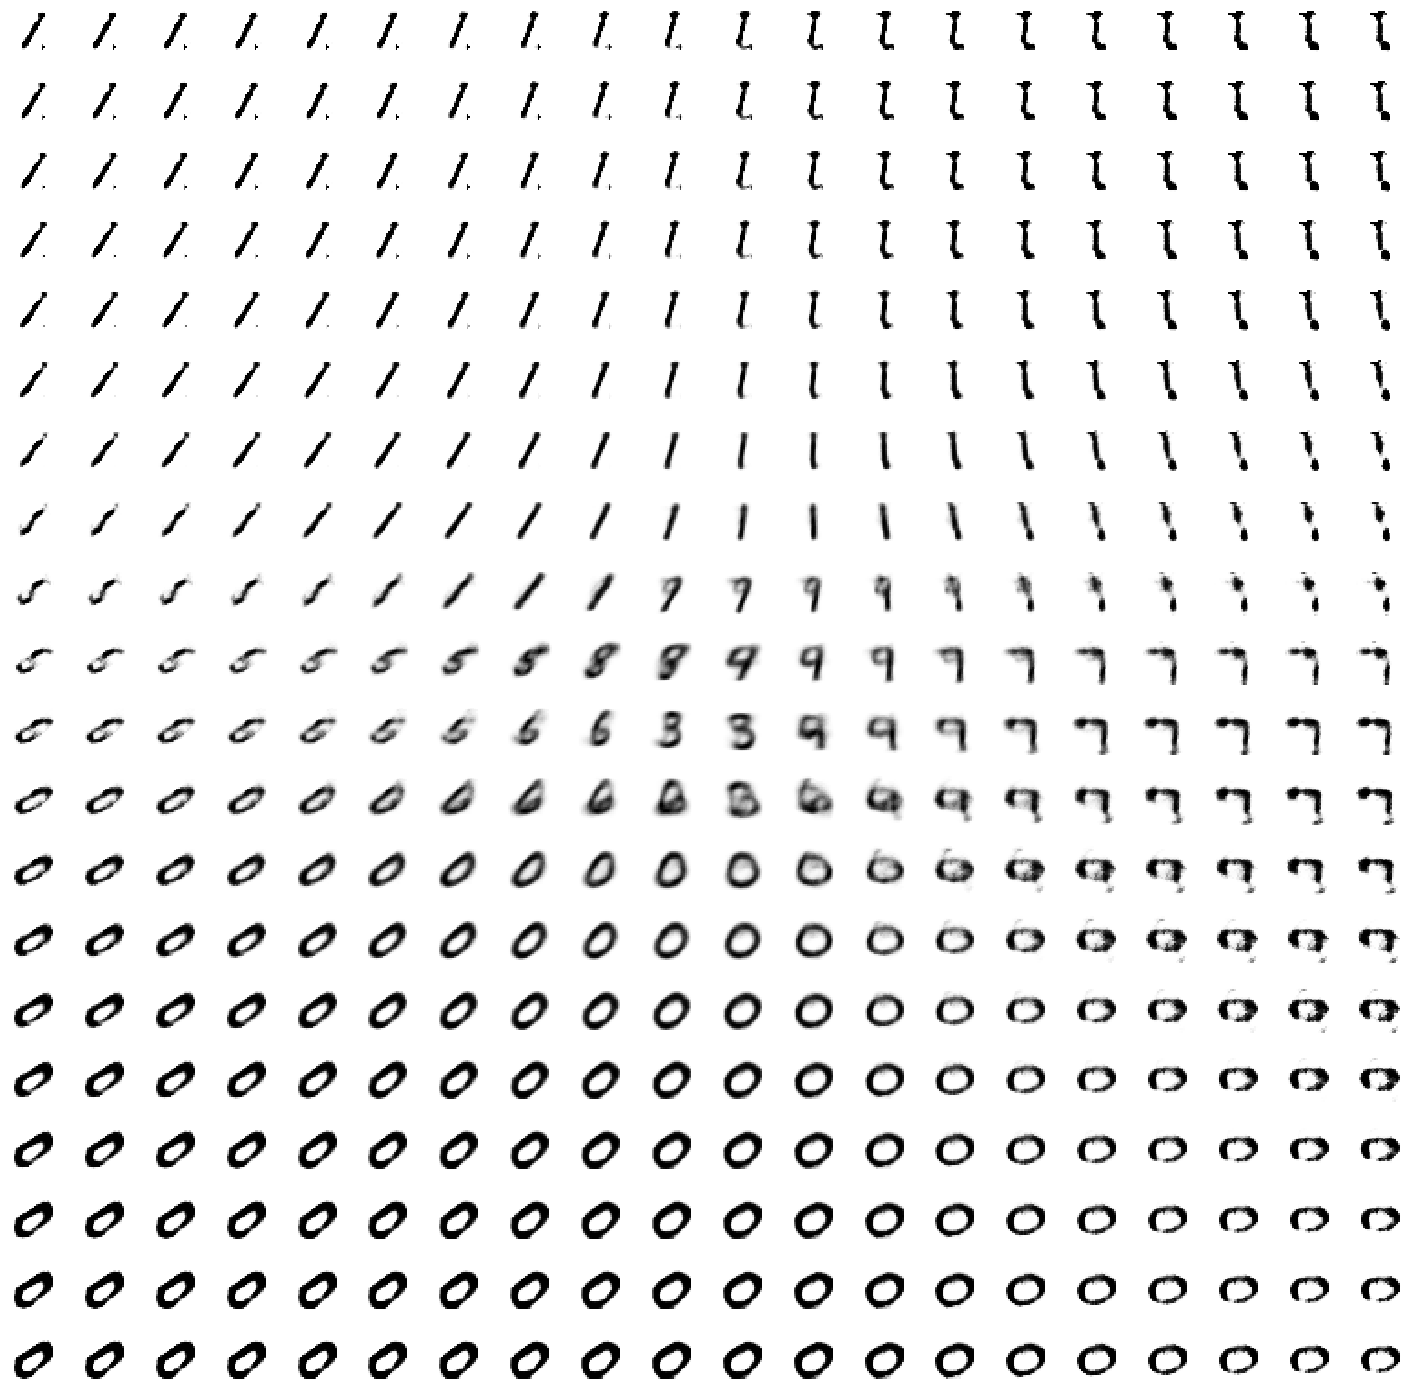

In [79]:
""" Display the constructions on the extreme values of the manifold"""

fig, axes = plt.subplots(20, 20, figsize=(20, 20))

for i in range(20):
    for j in range(20):
        x_coord = (i / 19 - 0.5) * 2 * 8
        y_coord = (j / 19 - 0.5) * 2 * 8

        z = torch.from_numpy(np.array([x_coord, y_coord])[None, :]).float()

        decoded_vae = vae.decode(z, z)[0].squeeze().detach().numpy().reshape((28, 28))

        axes[i, j].imshow(decoded_vae, cmap="binary")
        axes[i, j].axis("off")
fig.tight_layout()
fig.subplots_adjust(hspace=0)
# plt.savefig("plots/mnist_manifold_8_range.pdf", dpi=300)
plt.show()


In [193]:
rv.cdf([0.0, 0.0])


0.25